In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from functools import reduce
import joblib


%matplotlib inline
pd.set_option("display.max_columns", None)
%config IPCompleter.greedy = True

In [2]:
route = pd.read_pickle("./route_79__.pkl")
bank_holidays = pd.read_pickle("./bank_holidays__.pkl")
weather = pd.read_pickle("./weather__.pkl")

In [4]:
weather.head()

,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,date,hour
0,Dublin,53.349805,-6.26031,4.15,-6.49,3.84,5.79,990,,,87,12.86,240,40,520,Rain,light intensity shower rain,09n,2018-01-01,0
1,Dublin,53.349805,-6.26031,3.71,-2.28,3.00,5.80,1008,,,75,5.66,240,40,802,Clouds,scattered clouds,03n,2018-01-02,0
2,Dublin,53.349805,-6.26031,5.18,-3.85,5.00,6.66,985,,,87,10.80,260,75,520,Rain,light intensity shower rain,09n,2018-01-03,0
3,Dublin,53.349805,-6.26031,6.06,0.07,5.31,7.29,996,,,87,6.69,230,75,803,Clouds,broken clouds,04n,2018-01-04,0
4,Dublin,53.349805,-6.26031,4.09,-0.08,3.24,5.68,990,,,87,3.60,220,75,803,Clouds,broken clouds,04n,2018-01-05,0


In [5]:
def route_time_process(df):
    df['hour'] = (df['ActualTime_Arr']//3600) % 24
    return df
route =route_time_process(route)

In [8]:
route.drop(['temp'],axis =1, inplace = True)

In [9]:
def convert_2_datetime(df, col):
    df[col] = pd.to_datetime(df[col]) 
    return df
route = convert_2_datetime(route, 'DayOfService')
bank_holidays = convert_2_datetime(bank_holidays, 'date')
weather = convert_2_datetime(weather, 'date')

In [10]:
def add_bank_holiday(df, col, bank_holidays, date_col):
    df['bank_holiday'] = np.where(df[col].astype(str).isin(set(list(bank_holidays[date_col].astype(str)))),1,0)
    return df
route = add_bank_holiday(route, 'DayOfService', bank_holidays, 'date')

In [11]:
route[route['bank_holiday'] == 1].tail(10)

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate,date,hour,wind_speed,weather_main,weather_description,morning_rush,evening_rush,bank_holiday,weekday
693772,2018-12-26,8587886,79,79_10,18,2652,1,85908,84600,85386,85386,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693773,2018-12-26,8587886,79,79_10,19,2653,1,85908,84600,85395,85395,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693774,2018-12-26,8587886,79,79_10,20,2654,1,85908,84600,85402,85402,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693775,2018-12-26,8587886,79,79_10,21,2655,1,85908,84600,85454,85444,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693776,2018-12-26,8587886,79,79_10,22,2656,1,85908,84600,85489,85489,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693777,2018-12-26,8587886,79,79_10,23,2657,1,85908,84600,85532,85532,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693778,2018-12-26,8587886,79,79_10,24,2658,1,85908,84600,85592,85552,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693779,2018-12-26,8587886,79,79_10,25,2659,1,85908,84600,85681,85681,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693780,2018-12-26,8587886,79,79_10,1,326,1,85908,84600,84609,84609,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2
693781,2018-12-26,8587886,79,79_10,5,4407,1,85908,84600,84833,84833,09-JAN-19 17:30:44,2018-12-26,23,1.5,Clouds,broken clouds,N,N,1,2


In [12]:
col = ['Direction', 'hour', 'StopPointID', 'ProgrNumber','temp', 
       'day_of_week','day_of_year', 'journey_time']

def merge_and_clean(df1, df2, col):
    combined_df = pd.merge(df1, df2,  how='inner', left_on=['DayOfService', 'hour'], 
                           right_on = ['date', 'hour'],
                           suffixes=('_route','_weather'))
    combined_df['Direction'] = combined_df['Direction'].astype('int')
    combined_df['day_of_week'] = combined_df['DayOfService'].dt.dayofweek
    combined_df['day_of_year'] = combined_df['DayOfService'].dt.dayofyear
    combined_df['journey_time'] = combined_df['ActualTime_Dep'] - combined_df['PlannedTime_Arr']
    combined_df['journey_time'] = combined_df['journey_time'].apply(lambda x: x if x > 0 else 0)
    combined_df['StopPointID'] = combined_df['StopPointID'].astype('category')
    combined_df = combined_df[col]
    return combined_df
df = merge_and_clean(route, weather, col)

In [13]:
df.head(20)

,Direction,hour,StopPointID,ProgrNumber,temp,day_of_week,day_of_year,journey_time
0,2,10,1358,30,5.02,0,1,1724
1,2,10,1476,26,5.02,0,1,1307
2,2,10,1480,28,5.02,0,1,1499
3,2,10,2663,5,5.02,0,1,204
4,2,10,2664,6,5.02,0,1,248
5,2,10,2665,7,5.02,0,1,300
6,2,10,2666,8,5.02,0,1,330
7,2,10,2667,9,5.02,0,1,370
8,2,10,2670,1,5.02,0,1,10
9,2,10,2696,10,5.02,0,1,462


In [14]:
# fig, ax = plt.subplots(figsize=(24,6))
# ax = sns.countplot(x="weather_main", data=df)
# plt.xticks(rotation=45)

In [15]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [16]:
def remove_outlier(df):    
    df = df[np.abs(df["journey_time"]-df["journey_time"].mean())<=(1.5*df["journey_time"].std())]
    return df

In [17]:
# df = one_hot_encoding(df, ['StopPointID'])
print ("Shape Of The Before Ouliers: ",df.shape)
df = remove_outlier(df)
print ("Shape Of The After Ouliers: ",df.shape)

Shape Of The Before Ouliers:  (704735, 8)
Shape Of The After Ouliers:  (631105, 8)


In [18]:
# fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,16))
# sns.boxplot(data=df,y="journey_time",x="bank_holiday",orient="v",ax=axes[0][0])
# sns.boxplot(data=df,y="journey_time",x="day_of_week",orient="v",ax=axes[0][1])
# sns.boxplot(data=df,y="journey_time",x="day_of_year",orient="v",ax=axes[1][0])
# sns.boxplot(data=df,y="journey_time",x="hour",orient="v",ax=axes[1][1])
# axes[0][0].set(ylabel='bank_holiday')
# axes[0][1].set(xlabel='day_of_week', ylabel='journey_time')
# axes[1][0].set(xlabel='day_of_year', ylabel='journey_time')
# axes[1][1].set(xlabel='hour', ylabel='journey_time')

In [19]:
#Slow runnimg

#Finding distribution between different time
# fig, axes = plt.subplots(ncols=2, figsize=(16,6))
# sns.barplot(data=df, y = 'journey_time', x = 'hour', ax=axes[0])
# sns.barplot(data=df, y = 'journey_time', x = 'day_of_week', ax=axes[1])

In [20]:
#Finding correlation of continuous features
# col = ['hour', 'bank_holiday',
#        'temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all',
#        'day_of_week', 'day_of_year', 'journey_time']
# corrMatt = df[col].corr()
# mask = np.array(corrMatt)
# mask[np.tril_indices_from(mask)] = False
# fig,ax= plt.subplots(figsize=(16,12))
# sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
# plt.show()

In [21]:
# fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
# sns.distplot(df["temp"],ax=axes[0][0])
# sns.distplot(df["pressure"],ax=axes[0][1])
# sns.distplot(df["humidity"],ax=axes[1][0])
# sns.distplot(df["wind_speed"],ax=axes[1][1])
# sns.distplot(df["clouds_all"],ax=axes[2][0])
# sns.distplot(df["journey_time"],ax=axes[2][1])

# axes[0][0].set(xlabel='temp', ylabel='d')
# axes[0][1].set(xlabel='pressure', ylabel='d')
# axes[1][0].set(xlabel='humidity', ylabel='d')
# axes[1][1].set(xlabel='wind_speed', ylabel='d')
# axes[2][0].set(xlabel='clouds_all', ylabel='d')
# axes[2][1].set(xlabel='journey_time', ylabel='d')

In [22]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [23]:
df = time_transform(df, 'day_of_week', 7)
df = time_transform(df, 'hour', 24)

In [24]:
y = df['journey_time']
x = df.loc[:, df.columns != 'journey_time']

In [25]:
y_avg = y.mean()
y_avg

994.8596746975543

In [26]:
size = len(x) * 9 //10 
x_train, x_test = x[:size], x[size:]
y_train, y_test = y[:size], y[size:]
print(size)

567994


In [27]:
x_train.dtypes

Direction             int64
StopPointID        category
ProgrNumber           int64
temp                float64
day_of_year           int64
day_of_week_sin     float64
day_of_week_cos     float64
hour_sin            float64
hour_cos            float64
dtype: object

In [28]:
%%time
#Model validation
lgb_turned = lgb.LGBMRegressor()
lgb_turned.fit(x_train, y_train, categorical_feature=['StopPointID'])
b
print(scores_rmse)
print("- RMSE: {:.5f}".format(np.mean(scores_rmse)))
print("- MAE: {:.5f}".format(np.mean(scores_mae)))

/Users/pie_trick/Desktop/Semester3/venv/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['StopPointID']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[-181.65485429 -184.68770493 -185.44459438 -171.4990878  -193.88033315]
- RMSE: -183.43331
- MAE: -133.74586
CPU times: user 1min 54s, sys: 2.49 s, total: 1min 57s
Wall time: 15.8 s


In [29]:
model_name = 'route_79A__lgbm_model.pkl'
joblib.dump(lgb_turned, model_name)

['route_79A__lgbm_model.pkl']

In [30]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 696 ms, sys: 14.1 ms, total: 710 ms
Wall time: 107 ms


In [31]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_absolute_error(y_test, y_prediction)

167.20469702862115

In [32]:
_prediction = pd.Series(y_prediction)

In [33]:
x_test

,Direction,StopPointID,ProgrNumber,temp,day_of_year,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
633159,2,1480,28,7.19,326,0.433884,-0.900969,-0.258819,-9.659258e-01
633160,2,2663,5,7.19,326,0.433884,-0.900969,-0.258819,-9.659258e-01
633161,2,2664,6,7.19,326,0.433884,-0.900969,-0.258819,-9.659258e-01
633162,2,2665,7,7.19,326,0.433884,-0.900969,-0.258819,-9.659258e-01
633163,2,2666,8,7.19,326,0.433884,-0.900969,-0.258819,-9.659258e-01
...,...,...,...,...,...,...,...,...,...
704730,1,2907,31,8.86,365,0.000000,1.000000,1.000000,6.123234e-17
704731,1,2908,32,8.86,365,0.000000,1.000000,1.000000,6.123234e-17
704732,1,2909,29,8.86,365,0.000000,1.000000,1.000000,6.123234e-17
704733,1,326,1,8.86,365,0.000000,1.000000,1.000000,6.123234e-17


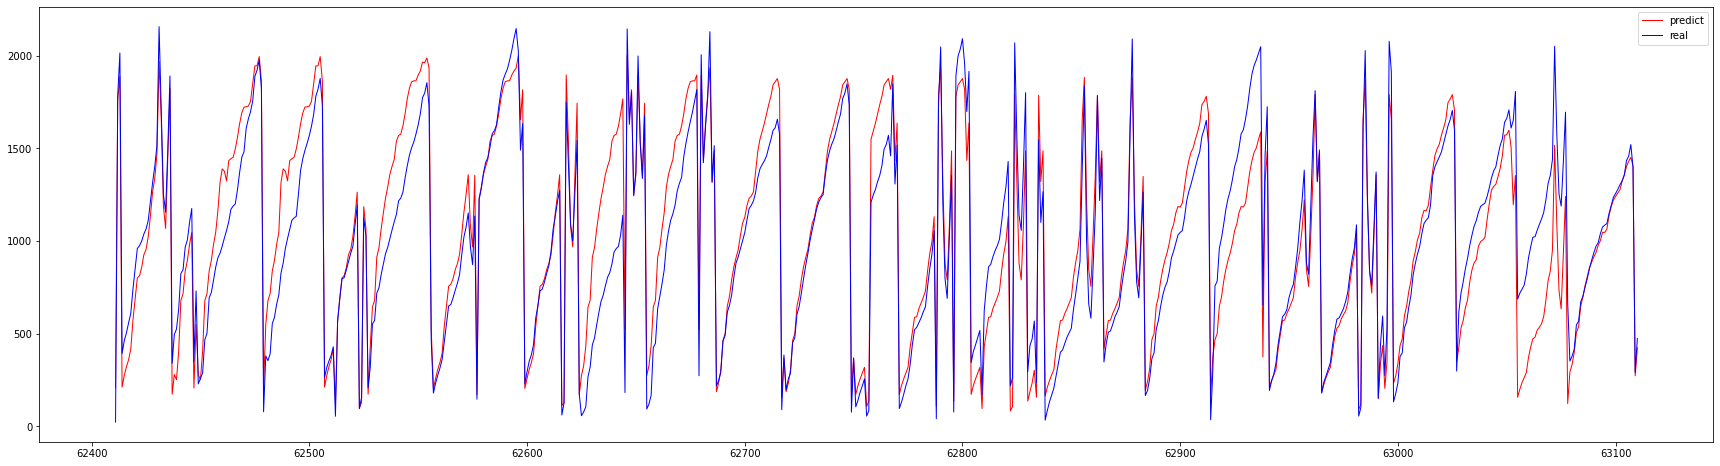

In [34]:
fig, ax = plt.subplots(figsize=(30,8))
plt.plot(_prediction[-700:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-700:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

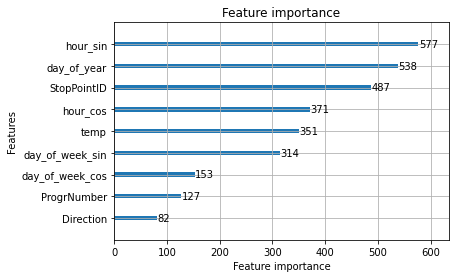

In [35]:
lgb.plot_importance(model)

In [50]:
"Thomas Street, stop 1938".split(',')[0]

'Thomas Street'

In [52]:
x = pd.read_csv('routesstops.csv')

In [57]:
routesstops_cache = dict()
for index, row in x.iterrows():
    routesstops_cache[(row['route'].strip(), row['stop_name'].strip())] = row['stopid']

In [61]:
import pprint
pd.options.display.max_rows = 100000
pprint.pprint(routesstops_cache)

{('1', 'Bath Street'): 391,
 ('1', 'Botanic Avenue'): 46,
 ('1', "DCU St Patrick's"): 45,
 ('1', 'DCU St Patrick‚Äôs'): 7602,
 ('1', 'Dargle Road'): 18,
 ('1', 'Dorset Street Lower'): 49,
 ('1', 'Dorset Street Upper'): 52,
 ('1', 'Dromard Terrace'): 375,
 ('1', 'Drumcondra Rail Stn'): 47,
 ('1', 'Ellenfield Park'): 1641,
 ('1', 'Erne Street'): 398,
 ('1', 'Farney Park'): 388,
 ('1', 'Fitzroy Avenue'): 48,
 ('1', 'Gilford Road'): 383,
 ('1', 'Grand Canal Quay'): 396,
 ('1', 'Griffith Downs'): 4432,
 ('1', 'Highfield Hospital'): 214,
 ('1', 'Innisfallen Parade'): 15,
 ('1', 'Irishtown Road'): 371,
 ('1', 'Iveragh Road'): 213,
 ('1', 'Lea Road'): 384,
 ('1', 'Newgrove Avenue'): 385,
 ('1', "O'Connell St Lower"): 271,
 ('1', "O'Connell St Upper"): 278,
 ('1', 'Oldtown Road'): 229,
 ('1', 'Parnell Square East'): 265,
 ('1', 'Parnell Square West'): 10,
 ('1', 'Pearse Square'): 397,
 ('1', 'Pearse Station'): 399,
 ('1', "Prince's St South"): 350,
 ('1', 'Ringsend'): 392,
 ('1', 'Ringsend Gara

 ('140', 'Finglas Road'): 4542,
 ('140', 'Fire Station'): 196,
 ('140', 'Frankfort Avenue'): 1024,
 ('140', 'Glasnevin Cemetery'): 1536,
 ('140', 'Grantham Street'): 7577,
 ('140', 'Grove Park'): 4528,
 ('140', 'Hampton Wood'): 6363,
 ('140', 'Hampton Wood Road'): 6367,
 ('140', 'IKEA'): 7276,
 ('140', 'Jamestown Road'): 6361,
 ('140', 'Lanesborough Avenue'): 6365,
 ('140', 'Lanesborough Estate'): 4985,
 ('140', 'Lanesborough View'): 7111,
 ('140', 'Lindsay Grove'): 186,
 ('140', 'Mayeston Lawn'): 6362,
 ('140', 'McKelvey Avenue'): 1558,
 ('140', 'Meakstown Centre'): 6230,
 ('140', 'Melville'): 6229,
 ('140', 'Military Road'): 1019,
 ('140', 'Monck Place'): 197,
 ('140', 'Munster Street'): 199,
 ('140', 'North Circular Road'): 188,
 ('140', "O'Connell St Upper"): 274,
 ('140', 'Palmerston Park'): 896,
 ('140', 'Palmerston Road'): 897,
 ('140', 'Palmeston Villas'): 895,
 ('140', 'Parnell Square East'): 264,
 ('140', 'Parnell Square West'): 7,
 ('140', 'Phibsborough Road'): 187,
 ('140',

 ('15b', 'Rathmines Rd Lower'): 1017,
 ('15b', "Redmond's Hill"): 7579,
 ('15b', 'Ringsend Road'): 395,
 ('15b', 'Riversdale Avenue'): 2918,
 ('15b', 'Rosemount SC'): 7064,
 ('15b', "S Great George's St"): 1283,
 ('15b', 'Scholarstown Road'): 7445,
 ('15b', 'Shaw Street'): 400,
 ('15b', 'South Richmond St'): 1072,
 ('15b', 'Spire View Lane'): 1168,
 ('15b', "St Enda's GAA Club"): 7444,
 ('15b', "St Mary's College"): 1071,
 ('15b', 'Stocking Avenue'): 6288,
 ('15b', 'Stocking Hill'): 6342,
 ('15b', 'Stocking Lane'): 6339,
 ('15b', 'Stocking Wood'): 6287,
 ('15b', 'Swan Centre'): 1076,
 ('15b', 'Templeroan Estate'): 7446,
 ('15b', 'Townsend Street'): 340,
 ('15b', 'Washerwomans Lane'): 3002,
 ('15b', 'Winton Avenue'): 1166,
 ('15b', 'Woodstown'): 6286,
 ('15b', 'Zion Road'): 2988,
 ('15d', 'Auburn Villas'): 1080,
 ('15d', 'Aungier Street'): 1354,
 ('15d', 'Ballyboden Church'): 2955,
 ('15d', 'Ballyboden Crescent'): 2948,
 ('15d', 'Ballyboden Road'): 2941,
 ('15d', 'Ballyroan Road'): 7065

 ('27a', 'Annesley Bridge Road'): 521,
 ('27a', 'Bayview Avenue'): 4384,
 ('27a', 'Brian Road'): 667,
 ('27a', 'Brookwood Ave'): 1801,
 ('27a', 'Brookwood Grove'): 1782,
 ('27a', 'Buckingham St Lower'): 675,
 ('27a', 'Bus?°ras'): 496,
 ('27a', 'Casino Park'): 665,
 ('27a', 'Clonrosse Drive'): 1789,
 ('27a', 'Connolly'): 497,
 ('27a', 'Danieli Road'): 1219,
 ('27a', 'Donnycarney Church'): 664,
 ('27a', 'Donnycarney Road'): 672,
 ('27a', 'Edenmore Avenue'): 638,
 ('27a', 'Edenmore Drive'): 629,
 ('27a', 'Edenmore Green'): 642,
 ('27a', 'Edenmore Grove'): 640,
 ('27a', 'Edenmore Park'): 639,
 ('27a', 'Elm Mount Road'): 1196,
 ('27a', 'Fairview'): 614,
 ('27a', 'Glenfarne Road'): 636,
 ('27a', 'Glenwood Road'): 635,
 ('27a', 'Gorsefield Court'): 1784,
 ('27a', 'Gracefield Road'): 4782,
 ('27a', 'Grange Road'): 959,
 ('27a', 'Howth Junction'): 957,
 ('27a', 'Killester Avenue'): 1220,
 ('27a', 'Lady of Mercy Church'): 1800,
 ('27a', 'Lein Gardens'): 625,
 ('27a', 'Lein Park'): 644,
 ('27a', 

 ('33', 'Kilbrush Lane'): 3836,
 ('33', 'Lissenhall Green'): 6050,
 ('33', 'Loughshinny Cross'): 3829,
 ('33', 'Lusk House'): 3852,
 ('33', 'Lusk Road'): 3761,
 ('33', 'Millbank Court'): 3842,
 ('33', 'Mine Road'): 3828,
 ('33', 'Morton Stadium'): 1638,
 ('33', 'Mountjoy Sq West'): 1174,
 ('33', 'Mourne Drive'): 3816,
 ('33', 'Mourne View'): 3802,
 ('33', 'N1 Business Park'): 3696,
 ('33', 'Newhaggard'): 3861,
 ('33', 'North Cliff Heights'): 3801,
 ('33', 'North Street'): 3712,
 ('33', 'Northcliffe Heights'): 3815,
 ('33', "O'Connell St Upper"): 277,
 ('33', 'Old Market Green'): 7173,
 ('33', 'Old Road'): 7172,
 ('33', 'Omni Park SC'): 1640,
 ('33', 'Orlynn Park'): 3853,
 ('33', 'Palmer Road'): 3834,
 ('33', 'Peter & Paul Church'): 7174,
 ('33', 'Pierstown Lane'): 3826,
 ('33', 'Pinnock Hill'): 3694,
 ('33', 'Racecourse Commons'): 3856,
 ('33', 'Railway Street'): 1172,
 ('33', 'Rogerstown Lane'): 3850,
 ('33', 'Rosewood'): 3851,
 ('33', 'Rush & Lusk Stn'): 3849,
 ('33', 'Rush Athletic 

 ('39a', 'Waterloo Road'): 779,
 ('39a', 'Wellington Lane'): 755,
 ('39a', 'Whitestown'): 1867,
 ('39a', 'Whitestown Park'): 1850,
 ('39a', 'Willow Wood'): 1859,
 ('39x', 'Allendale Close'): 6111,
 ('39x', 'Ashtown Roundabout'): 1696,
 ('39x', 'Aston Quay'): 328,
 ('39x', 'Bachelors Walk'): 315,
 ('39x', 'Baggot Road'): 1700,
 ('39x', 'Baggot St Lower'): 783,
 ('39x', 'Baggot St Upper'): 752,
 ('39x', 'Barnwell Green'): 7048,
 ('39x', 'Beechwood Gate'): 7699,
 ('39x', 'Blackhall Place'): 1715,
 ('39x', 'Burlington Road'): 7339,
 ('39x', 'Castlegrange Row'): 7018,
 ('39x', 'Civic Offices'): 1443,
 ('39x', 'Dawson Street'): 793,
 ('39x', 'Delhurst'): 7161,
 ('39x', 'Dunard'): 1805,
 ('39x', 'Embassy of Malta'): 786,
 ('39x', 'Four Courts'): 1478,
 ('39x', 'Hansfield Road'): 7162,
 ('39x', 'Hawkins Street'): 4495,
 ('39x', 'Herbert Street'): 751,
 ('39x', 'Latchfort Court'): 7038,
 ('39x', 'Lohunda Park'): 6113,
 ('39x', 'Manor Street'): 1713,
 ('39x', 'Merrion Sq West'): 2810,
 ('39x', '

 ('41x', 'Seatown Road'): 7114,
 ('41x', 'Seatown Villas'): 3752,
 ('41x', 'St Colmcille GAA'): 4924,
 ('41x', "St Cronan's Avenue"): 4913,
 ('41x', "St Cronan's Lawn"): 4907,
 ('41x', "Stephen's Green East"): 842,
 ('41x', "Stephen's Green Nth"): 790,
 ('41x', 'Sussex Road'): 848,
 ('41x', 'Swords Park'): 7116,
 ('41x', 'Teresian School'): 771,
 ('41x', 'UCD'): 4953,
 ('41x', 'UCD N11 Entrance'): 768,
 ('41x', 'Valley View'): 4914,
 ('41x', 'Victoria Avenue'): 758,
 ('42', 'Amiens Street'): 619,
 ('42', 'Annesley Bridge'): 615,
 ('42', 'Annesley Bridge Road'): 521,
 ('42', 'Auburn House'): 3645,
 ('42', 'Balgriffin Cottages'): 1217,
 ('42', 'Baskin Lane'): 3662,
 ('42', 'Bayview Avenue'): 4384,
 ('42', 'Belcamp Lane'): 6115,
 ('42', 'Blackwood Lane'): 7327,
 ('42', 'Brian Road'): 667,
 ('42', 'Brookville Cresent'): 1201,
 ('42', 'Buckingham St Lower'): 675,
 ('42', 'Casino Park'): 665,
 ('42', 'Chanel College'): 1200,
 ('42', 'Chapel Road'): 3575,
 ('42', 'Church Street'): 3633,
 ('42

 ('54a', 'Fortfield Drive'): 2400,
 ('54a', 'Fortfield Park'): 2406,
 ('54a', 'Fortfield Road'): 2408,
 ('54a', 'Glendown Avenue'): 2403,
 ('54a', 'Glenview Lawn'): 2596,
 ('54a', 'Glenview Park'): 2554,
 ('54a', "Harold's Cross Road"): 1291,
 ('54a', 'IT Tallaght'): 4436,
 ('54a', 'Killinarden Estate'): 2571,
 ('54a', 'Kimmage Grove'): 2441,
 ('54a', 'Kimmage Road Lower'): 2438,
 ('54a', 'Lavarna'): 2412,
 ('54a', 'Le Vere Terrace'): 1345,
 ('54a', 'Lifegate Church'): 2594,
 ('54a', 'Limekiln Drive'): 1111,
 ('54a', 'Lombard Street West'): 2635,
 ('54a', 'Long Lane'): 2387,
 ('54a', 'Maplewood Avenue'): 2359,
 ('54a', 'Marlfield'): 5161,
 ('54a', 'Marlfield Drive'): 5024,
 ('54a', 'Mount Argus Church'): 2442,
 ('54a', 'Mount Argus Park'): 2390,
 ('54a', 'Mount Argus Road'): 2444,
 ('54a', 'New Street South'): 2636,
 ('54a', 'Osprey Road'): 1100,
 ('54a', 'Patrick Street'): 2385,
 ('54a', "Patrick's Cathedral"): 2383,
 ('54a', 'Poddle Park'): 2394,
 ('54a', 'Ravensdale Park'): 2439,
 (

 ('66x', 'Heuston Station'): 4413,
 ('66x', 'Hewlett Packard'): 4003,
 ('66x', 'Highfield Park'): 4405,
 ('66x', 'Hillcrest'): 7050,
 ('66x', 'Intel Entrance 1'): 3986,
 ('66x', 'Intel Entrance 2'): 3965,
 ('66x', 'Intel Extrance 2'): 3985,
 ('66x', 'Kennelsfort'): 4401,
 ('66x', 'Kennelsfort Road'): 2241,
 ('66x', 'Kew Park'): 7187,
 ('66x', 'Kingsbry'): 5114,
 ('66x', 'Leixlip'): 3998,
 ('66x', 'Leixlip Amenities'): 3987,
 ('66x', 'Leixlip GAA Club'): 6156,
 ('66x', 'Leixlip Park'): 5112,
 ('66x', 'Liffey Valley Golf'): 4001,
 ('66x', 'Liffey Valley SC'): 2239,
 ('66x', 'Louisa Bridge Stn'): 3989,
 ('66x', 'Lucan Spa Hotel'): 7186,
 ('66x', 'Maynooth'): 5113,
 ('66x', 'Maynooth SC'): 3982,
 ('66x', 'Memorial Gardens'): 7435,
 ('66x', "Merchant's Quay"): 1444,
 ('66x', 'Merrion Sq West'): 2810,
 ('66x', 'Morehampton Terrace'): 776,
 ('66x', 'National Gallery'): 7585,
 ('66x', 'Oaklawn'): 6165,
 ('66x', 'Old Greenfield Rd'): 6089,
 ('66x', 'Old Hill'): 7234,
 ('66x', 'Ormond Quay Upper

 ('747', 'Maldron Hotel'): 3669,
 ('747', 'Mayor Street Lower'): 5140,
 ('747', 'New Wapping Street'): 2501,
 ('747', "O'Connell St Lower"): 271,
 ('747', 'Parnell Square East'): 263,
 ('747', 'Railway Street'): 1172,
 ('747', 'Sarsfield Quay'): 1476,
 ('747', 'Talbot Street'): 620,
 ('747', 'The Point'): 7399,
 ('747', "Usher's Quay"): 1445,
 ('757', 'Adelaide Road'): 1015,
 ('757', 'Baggot St Lower'): 749,
 ('757', 'Br an Phoirt Thoir'): 7623,
 ('757', 'Clare Street'): 494,
 ('757', 'Convention Centre'): 7398,
 ('757', 'Custom House Quay'): 2499,
 ('757', 'Earlsfort Terrace'): 6074,
 ('757', 'Eden Quay'): 301,
 ('757', 'Guild Street'): 7397,
 ('757', 'Harcourt Luas'): 1074,
 ('757', 'Hawkins Street'): 4495,
 ('757', 'Huguenot Cemetery'): 748,
 ('757', 'Maldron Hotel'): 3669,
 ('757', 'Merrion Street'): 2811,
 ('757', 'New Wapping Street'): 2501,
 ('757', 'North Wall Quay'): 6252,
 ('757', 'Pearse Station'): 495,
 ('757', 'Pearse Street'): 7588,
 ('757', "Stephen's Green East"): 842,


 ('83a', 'Met Eireann'): 182,
 ('83a', 'Military Road'): 1019,
 ('83a', 'Monck Place'): 197,
 ('83a', 'Munster Street'): 199,
 ('83a', 'North Circular Road'): 188,
 ('83a', 'Northland Grove'): 175,
 ('83a', 'Oakwood Road'): 4788,
 ('83a', 'Old Finglas Road'): 176,
 ('83a', 'Ormond Quay Upper'): 1479,
 ('83a', 'Phibsborough Road'): 187,
 ('83a', 'Phibsborough SC'): 198,
 ('83a', 'Pleasants Street'): 1353,
 ('83a', 'Prospect Way'): 200,
 ('83a', 'Rathmines'): 1070,
 ('83a', 'Rathmines Garda Stn'): 1170,
 ('83a', 'Rathmines Rd Lower'): 1017,
 ('83a', "Redmond's Hill"): 1284,
 ('83a', 'Rockmount'): 1556,
 ('83a', "S Great George's St"): 1283,
 ('83a', 'Scoil Colm'): 2466,
 ('83a', 'Scoil Una Naofa'): 2450,
 ('83a', 'South Richmond St'): 1072,
 ('83a', "St Brigid's School"): 154,
 ('83a', "St Canice's BNS"): 138,
 ('83a', "St Margaret's Road"): 6219,
 ('83a', "St Mary's College"): 1071,
 ('83a', "St Michan's Church"): 1616,
 ('83a', "St Teresa's Place"): 185,
 ('83a', 'Stannaway Ave'): 2492